# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [777]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [778]:
device = torch.device('cpu')

### Load 'names.txt' Dataset

In [779]:
names = open('names_all.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 6466, aabid, aabida, aachal, aadesh, aadil, ...


### Dictionaries to convert characters to int and back

In [780]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [782]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [783]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [784]:
X, Y = build_dataset(names, block_size=block_size)

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [787]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [788]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([38153]), torch.Size([4683]), torch.Size([4735]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [804]:
dims = 15
hidden_layer = 150
# dims = 5
# hidden_layer = 100

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [805]:
tanh_gain = 5/3
std = tanh_gain / (dims*block_size)**0.5

In [806]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims),                         generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer),   generator=g, device=device) * std
b1 = torch.randn(hidden_layer,                      generator=g, device=device) * 0.01

W2 = torch.randn((hidden_layer, 27),                generator=g, device=device) * 0.01
b2 = torch.randn(27,                                generator=g, device=device) * 0

bngain = torch.ones((1, hidden_layer))
bnbias = torch.zeros((1, hidden_layer))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"Total Parameter: {sum(p.nelement() for p in parameters)}")

Total Parameter: 11682


In [807]:
for p in parameters:
    p.requires_grad = True

In [808]:
losstrn = [] # For tracking loss during training

Function to calculate loss on given dataset

In [809]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Training
- `nitr` : Number of iterations - Set to 600K
- `lrs` : Array of learning rates - linear decay from 0.1 to 0.005
- Batch size for training: 64

In [810]:
nitr = 200000
# nitr = 40000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    hpreact = emb.view((-1, block_size*dims)) @ W1 + b1
    hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)  # BatchNorm
    hpreact = (hpreact * bngain) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)

In [811]:
logits[0]

tensor([ 3.9400,  3.3275, -2.5974, -1.0615, -0.2580,  3.0545, -3.0081, -1.0415,
        -0.0888,  4.6072, -0.8110,  1.3060, -0.5910, -0.9733,  1.7101, -1.7443,
         1.4015, -2.9945,  0.7622, -0.8443, -0.7517,  0.9157,  0.1587,  1.1281,
        -3.1552,  2.6386, -5.4302], grad_fn=<SelectBackward0>)

### Plot of log loss vs iterations

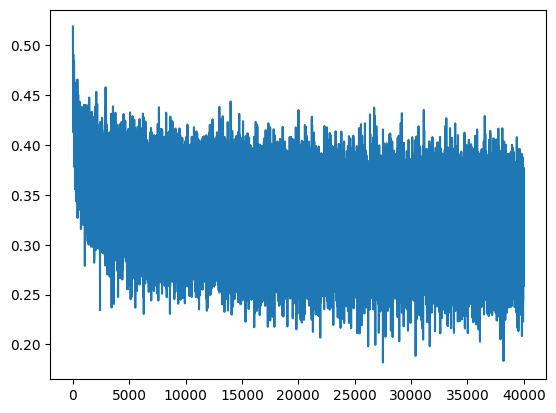

In [797]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

### Print the loss on the training, validation and testing datasets

In [798]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.0623245239257812
Validation Loss: 2.119180917739868
Testing Loss: 2.1295719146728516


(array([717., 330., 225., 196., 165., 108., 119., 138., 110.,  77.,  96.,
         96.,  90.,  73.,  74.,  88.,  61.,  66.,  70.,  39.,  59.,  61.,
         61.,  74.,  58.,  81.,  60.,  69.,  65.,  59.,  52.,  66.,  52.,
         79.,  57.,  64.,  69.,  76.,  76.,  95.,  98.,  86., 132., 143.,
        121., 221., 153., 203., 317., 655.]),
 array([-9.99988794e-01, -9.59989110e-01, -9.19989426e-01, -8.79989742e-01,
        -8.39990058e-01, -7.99990374e-01, -7.59990690e-01, -7.19991006e-01,
        -6.79991322e-01, -6.39991637e-01, -5.99991953e-01, -5.59992269e-01,
        -5.19992585e-01, -4.79992901e-01, -4.39993217e-01, -3.99993533e-01,
        -3.59993849e-01, -3.19994165e-01, -2.79994481e-01, -2.39994797e-01,
        -1.99995112e-01, -1.59995428e-01, -1.19995744e-01, -7.99960601e-02,
        -3.99963760e-02,  3.30805779e-06,  4.00029922e-02,  8.00026762e-02,
         1.20002360e-01,  1.60002044e-01,  2.00001729e-01,  2.40001413e-01,
         2.80001097e-01,  3.20000781e-01,  3.60000

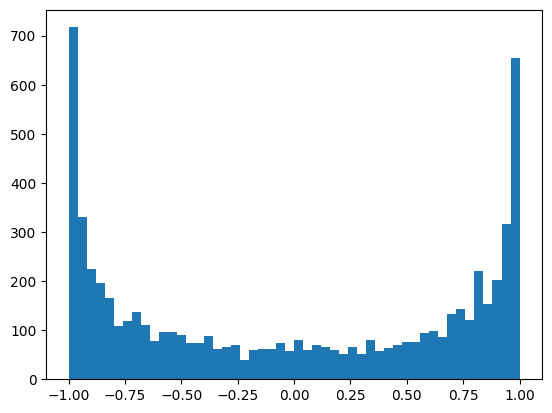

In [799]:
plt.hist(h.view(-1).tolist(), bins=50)

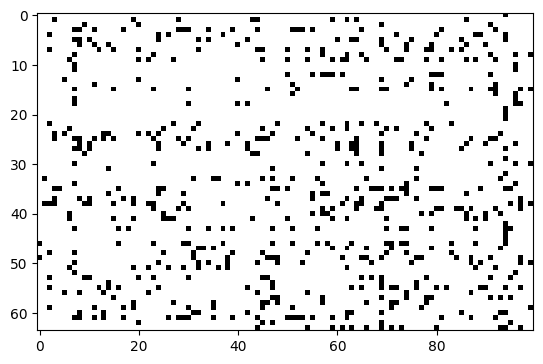

In [800]:
plt.imshow(h.abs() < 0.99, cmap='gray', interpolation='nearest')

(array([  1.,   2.,   4.,   3.,   7.,   8.,   3.,  15.,  21.,  26.,  36.,
         54.,  53.,  86.,  81., 139., 156., 171., 239., 235., 309., 336.,
        355., 340., 367., 317., 386., 332., 374., 303., 247., 223., 223.,
        159., 161., 126., 103., 108.,  98.,  59.,  47.,  22.,  13.,  18.,
         18.,   6.,   3.,   3.,   2.,   2.]),
 array([-6.72480202, -6.45783569, -6.19086937, -5.92390305, -5.65693672,
        -5.3899704 , -5.12300407, -4.85603775, -4.58907143, -4.3221051 ,
        -4.05513878, -3.78817245, -3.52120613, -3.25423981, -2.98727348,
        -2.72030716, -2.45334084, -2.18637451, -1.91940819, -1.65244186,
        -1.38547554, -1.11850922, -0.85154289, -0.58457657, -0.31761024,
        -0.05064392,  0.2163224 ,  0.48328873,  0.75025505,  1.01722137,
         1.2841877 ,  1.55115402,  1.81812035,  2.08508667,  2.35205299,
         2.61901932,  2.88598564,  3.15295197,  3.41991829,  3.68688461,
         3.95385094,  4.22081726,  4.48778358,  4.75474991,  5.02171623,
 

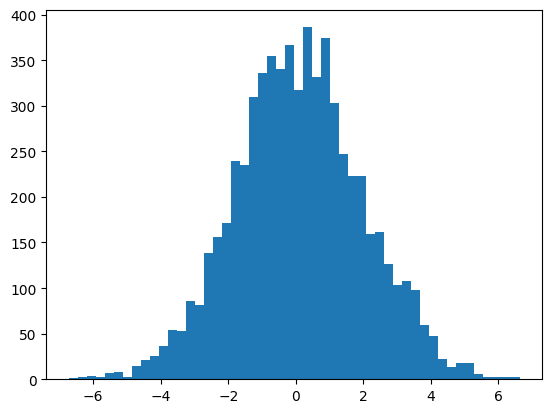

In [801]:
plt.hist((emb.view((-1, block_size*dims)) @ W1 + b1).view(-1).tolist(), bins=50)

### Function to generate a new word based using current model

In [802]:
@torch.no_grad
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view((1, -1)) @ W1 + b1
        hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)
        hpreact = (hpreact * bngain) + bnbias
        h = torch.tanh(hpreact)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [ ]:
for _ in range(20): print(generate())